### Compared cropped vs uncropped training images

In [1]:
import xarray as xr
import numpy as np
from google.cloud import storage
import gcsfs 
import torch
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import math

from torch import nn
from torch.nn import functional as F
import pickle


from torch.nn import functional as F
from torch.optim import Adam, AdamW, SGD
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.cuda.amp import GradScaler
from tqdm.notebook import tqdm
import time
import random

from torch.nn import ReLU, Sigmoid
from torch.nn import Module, Sequential 
from torch.nn import Conv3d, ConvTranspose3d, BatchNorm3d, MaxPool3d, AvgPool1d

In [2]:
class RemoteBucketDataset(Dataset):
    '''remotely read a sample from the bucket, within the training / test subset instances'''
    def __init__(self, bucket_name, indices):
        self.bucket_name = bucket_name
        self.indices = indices

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        input_data, target_data = self.load_data(self.indices[idx])
        #predict for probabilities to enhance training stability:
        return {'inputs': input_data, 'target': target_data/100.0}

    def load_data(self, idx):
        gcs = gcsfs.GCSFileSystem()
        # input_path = f"{self.bucket_name}/x_{idx}.nc"
        # target_path = f"{self.bucket_name}/y_{idx}.nc"
        input_path = f"{self.bucket_name}/x_{idx:04d}."
        target_path = f"{self.bucket_name}/y_{idx:04d}."
        #print(f"Loading input file from: {input_path}")

        with gcs.open(input_path, 'rb') as input_file, gcs.open(target_path, 'rb') as target_file:
            input_data = xr.open_dataset(input_file)
            target_data = xr.open_dataset(target_file)
        return input_data, target_data

def custom_collate(batch):
    """
    Custom collate function to handle xarray DataArrays in the batch using np.concatenate.
    """
    batch_inputs = [np.expand_dims(sample['inputs'].to_array().values, axis=0) for sample in batch]
    batch_targets = [np.expand_dims(sample['target'].to_array().values, axis=0) for sample in batch]

    # Concatenate and return tensors
    batch_inputs = np.concatenate(batch_inputs, axis=0)
    batch_targets = np.concatenate(batch_targets, axis=0)
    batch_inputs = torch.tensor(batch_inputs)
    batch_targets = torch.tensor(batch_targets)
    # return batch_inputs, batch_targets
    return {'inputs': batch_inputs, 'target': batch_targets}

def custom_collate_crop(batch, crop_size=(64, 64)):
    """
    Custom collate function to handle xarray DataArrays in the batch using np.concatenate.
    """
    batch_inputs = []
    batch_targets = []
    
    for sample in batch:
        # Convert DataArrays to numpy arrays
        input_array = sample['inputs'].to_array().values
        target_array = sample['target'].to_array().values
        
        # Randomly crop input and target arrays
        input_shape = input_array.shape[-2:]
        target_shape = target_array.shape[-2:]
        
        # Calculate maximum crop offsets
        max_x_offset = input_shape[0] - crop_size[0]
        max_y_offset = input_shape[1] - crop_size[1]
        
        # Randomly select crop offsets
        x_offset = random.randint(0, max_x_offset)
        y_offset = random.randint(0, max_y_offset)
        
        # Crop input and target arrays
        cropped_input = input_array[..., x_offset:x_offset+crop_size[0], y_offset:y_offset+crop_size[1]]
        cropped_target = target_array[..., x_offset:x_offset+crop_size[0], y_offset:y_offset+crop_size[1]]
        
        batch_inputs.append(np.expand_dims(cropped_input, axis=0))
        batch_targets.append(np.expand_dims(cropped_target, axis=0))

    # Concatenate and return tensors
    batch_inputs = np.concatenate(batch_inputs, axis=0)
    batch_targets = np.concatenate(batch_targets, axis=0)
    batch_inputs = torch.tensor(batch_inputs)
    batch_targets = torch.tensor(batch_targets)
    
    return {'inputs': batch_inputs, 'target': batch_targets}


num_samples = 1000
train_size = 800; test_size = 200
bucket_url = 'gs://terrakio-mass-requests-us/wcf'

# Create the dataset
indices = list(range(num_samples))

# Split the indices into training and test indices
train_indices = indices[:train_size]
test_indices = indices[train_size: train_size + test_size]

# Create the datasets
train_ds = RemoteBucketDataset(bucket_url, train_indices)
test_ds = RemoteBucketDataset(bucket_url, test_indices)

train_loader = DataLoader(train_ds, batch_size=8, num_workers = 4, collate_fn=custom_collate_crop)
test_loader = DataLoader(test_ds, batch_size=8, num_workers = 4, collate_fn=custom_collate)


In [3]:
from model.preprocessor_3d import PreprocessorTemp
preprocessor_t = PreprocessorTemp(in_channels = 6)
from model.UNet3D import UNet3D_convT
model = UNet3D_convT(num_channels=6)
device = torch.device('cuda')

In [4]:
# Create a random input tensor and move it to the CUDA device
x = torch.randn(1, 6, 4, 64, 64).to(device)
model.to(device)
# Count the total number of parameters in the model
total_params = sum(param.numel() for param in model.parameters())

# Perform the forward pass and measure the time taken
t = time.time()
out = model(x)
t = time.time() - t

print(f'model out_shape: {out.shape}, total_params: {total_params:,}, time: {t:.6f}')

model out_shape: torch.Size([1, 1, 64, 64]), total_params: 2,710,945, time: 0.493910


### Idea 1. Weigh the tails
    left_loss = torch.mean(mse_loss[left_tail_mask]) * left_tail_weight if left_tail_mask.any() else torch.tensor(0.0).to(targets.device)
    right_loss = torch.mean(mse_loss[right_tail_mask]) * right_tail_weight if right_tail_mask.any() else torch.tensor(0.0).to(targets.device)
    main_loss = torch.mean(mse_loss[non_weight_mask]) * main_weight if non_weight_mask.any() else torch.tensor(0.0).to(targets.device)


#### 1. 4 timesteps: [32, 64, 128, 256, 512] on (64, 64)

In [4]:
from model.test_funcs1 import test_unet_combineLoss_wInp_GS
torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark = True

In [ ]:
num_epochs = 10

optimiser = AdamW(model.parameters(), lr=1e-4, betas=(0.9, 0.99), eps=1e-8, weight_decay=0.01)
UNet_largeSet_inputs, UNet311_4steps_TestPairs,  UNet311_4steps_testLoss, UNet311_4steps_maeLoss = test_unet_combineLoss_wInp_GS(
    model, 'unet', preprocessor_t, train_loader, test_loader, optimiser, num_epochs, device = device)

print(UNet311_4steps_testLoss)
print(UNet311_4steps_maeLoss)

In [ ]:
torch.save(model.state_dict(), 'UNet311_4steps_weights.pth')

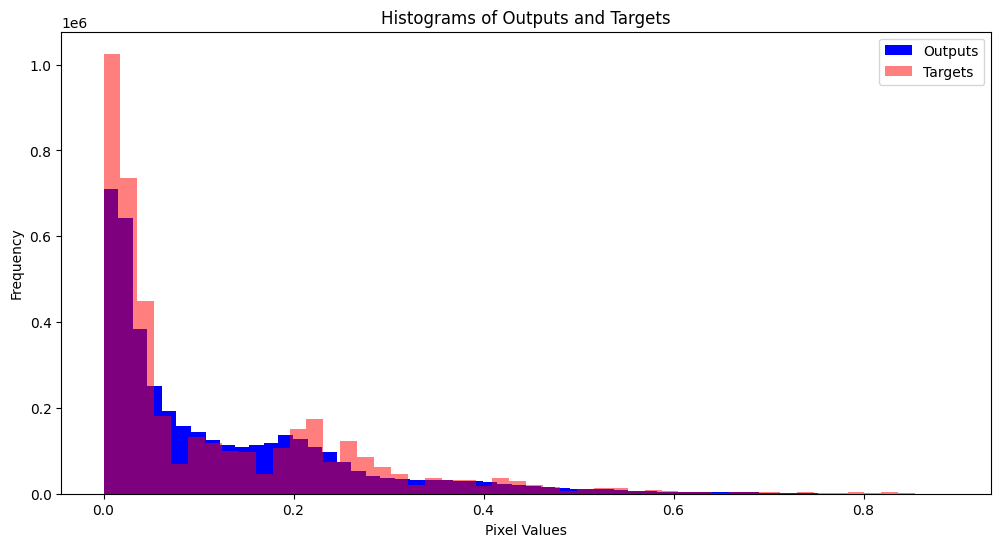

In [6]:
# Initialize empty lists to store flattened arrays
flattened_outputs = []
flattened_targets = []

# Flatten each output and target image and append to the respective lists
for i in range(len(UNet311_4steps_TestPairs)):
    output = UNet311_4steps_TestPairs[i][0].flatten()
    target = UNet311_4steps_TestPairs[i][1].flatten()
    flattened_outputs.extend(output.cpu())
    flattened_targets.extend(target.cpu())

# Convert lists to numpy arrays for easier manipulation
flattened_outputs = np.array(flattened_outputs)
flattened_targets = np.array(flattened_targets)

# Plot histograms
plt.figure(figsize=(12, 6))
plt.hist(flattened_outputs, bins=50, alpha=1.0, color='blue', label='Outputs')  # Dense color
plt.hist(flattened_targets, bins=50, alpha=0.5, color='red', label='Targets')  # More transparent color
plt.xlabel('Pixel Values')
plt.ylabel('Frequency')
plt.title('Histograms of Outputs and Targets')
plt.legend(loc='upper right')
plt.show()

---
#### 2. 12 timesteps: [16, 32, 64, 128, 256] on (64, 64)

In [ ]:
num_epochs = 10

optimiser = AdamW(model.parameters(), lr=1e-4, betas=(0.9, 0.99), eps=1e-8, weight_decay=0.01)
UNet_largeSet_inputs, UNet311_12steps_TestPairs,  UNet311_12steps_testLoss, UNet311_12steps_maeLoss = test_unet_combineLoss_wInp_GS(
    model, 'unet', preprocessor_t, train_loader, test_loader, optimiser, num_epochs, device = device)

print(UNet311_12steps_testLoss)
print(UNet311_12steps_maeLoss)

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [1/10], Train Loss: 0.5580382856726647


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [2/10], Train Loss: 0.0992726906016469


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [3/10], Train Loss: 0.04724409162066877


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [4/10], Train Loss: 0.049340478265658023


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [6/10], Train Loss: 0.038426111601293084


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [7/10], Train Loss: 0.036425555665045975


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [8/10], Train Loss: 0.03452833236195147


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [9/10], Train Loss: 0.024906478123739362


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [10/10], Train Loss: 0.033418675670400265


  0%|          | 0/25 [00:00<?, ?it/s]

0.04627907872200012
0.054744792878627775


In [ ]:
torch.save(model.state_dict(), 'UNet311_12steps_weights.pth')

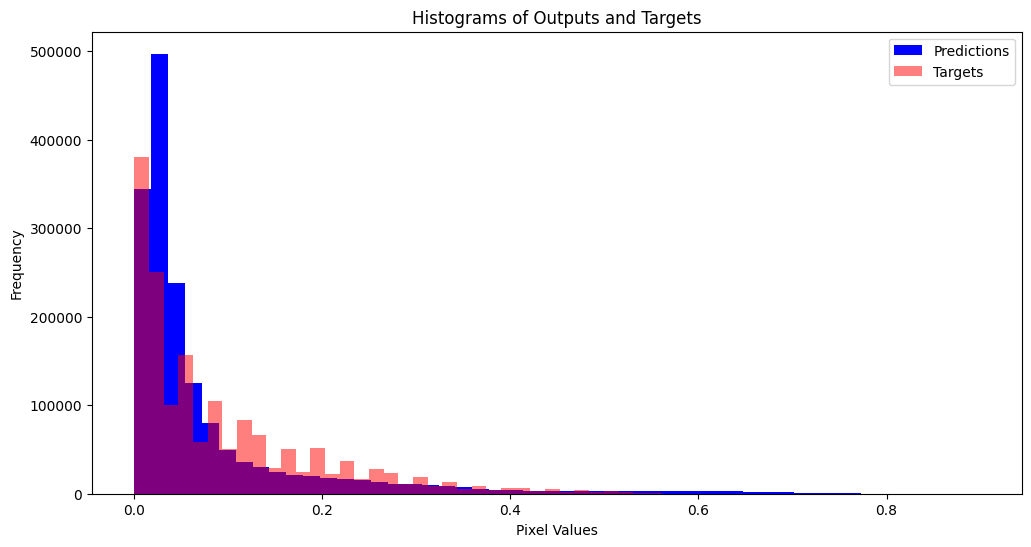

In [8]:
# Initialize empty lists to store flattened arrays
flattened_outputs = []
flattened_targets = []

# Flatten each output and target image and append to the respective lists
for i in range(len(UNet311_12steps_TestPairs)):
    output = UNet311_12steps_TestPairs[i][0].flatten()
    target = UNet311_12steps_TestPairs[i][1].flatten()
    flattened_outputs.extend(output.cpu())
    flattened_targets.extend(target.cpu())

# Convert lists to numpy arrays for easier manipulation
flattened_outputs = np.array(flattened_outputs)
flattened_targets = np.array(flattened_targets)

# Plot histograms
plt.figure(figsize=(12, 6))
plt.hist(flattened_outputs, bins=50, alpha=1.0, color='blue', label='Predictions')  # Dense color
plt.hist(flattened_targets, bins=50, alpha=0.5, color='red', label='Targets')  # More transparent color
plt.xlabel('Pixel Values')
plt.ylabel('Frequency')
plt.title('Histograms of Outputs and Targets')
plt.legend(loc='upper right')
plt.show()

In [4]:
# 12 timesteps: [8, 16, 32, 64, 128] on (64, 64)
x = torch.randn(1, 6, 12, 64, 64).to(device)
model.to(device)
# Count the total number of parameters in the model
total_params = sum(param.numel() for param in model.parameters())

# Perform the forward pass and measure the time taken
t = time.time()
out = model(x)
t = time.time() - t

print(f'model out_shape: {out.shape}, total_params: {total_params:,}, time: {t:.6f}')

model out_shape: torch.Size([1, 1, 64, 64]), total_params: 678,301, time: 0.494738


In [7]:
with open('UNet311_cropped_largeSet_TestPairs.pickle', 'wb') as f:
    pickle.dump(UNet311_cropped_largeSet_TestPairs, f)
with open('UNet_largeSet_inputs.pickle', 'wb') as f:
    pickle.dump(UNet_largeSet_inputs, f)

In [ ]:
with open('UNetconvT_TestPairs.pickle', 'rb') as f:    # small (3,1,1) UNet on (256,256)
    UNetconvT_TestPairs = pickle.load(f)
with open('UNet3115blk_largeSet_TestPairs.pickle', 'rb') as f:  # (3,1,1) UNet
    UNet3115blk_largeSet_TestPairs= pickle.load(f)
with open('UNet3115blk_ndvi_largeSet_TestPairs.pickle', 'rb') as f:    # (3,3,3) UNet
    UNet3115blk_ndvi_largeSet_TestPairs = pickle.load(f)
with open('UNet_3d_TestPairs.pickle', 'rb') as f:
    UNet_3d_TestPairs = pickle.load(f)
with open('UNet_3d_TestInp.pickle', 'rb') as f:
    UNet_3d_TestInp = pickle.load(f)

In [ ]:
def compute_error_metrics(output_map, target_map, delta=0.5):
    output_map = output_map.cpu().detach().numpy()
    target_map = target_map.cpu().detach().numpy()
    # Compute Huber loss between output and target maps
    absolute_errors = np.abs(output_map - target_map)
    mse = np.mean(absolute_errors ** 2)
    mae = np.mean(absolute_errors)
    return mse, mae

def quantify_errors(out_target_pairs):
    error_metrics_per_index = []
    for output_map, target_map in out_target_pairs:
        mse, mae= compute_error_metrics(output_map, target_map)
        error_metrics_per_index.append((mse, mae))
    return error_metrics_per_index


In [8]:
errors_311 = quantify_errors(UNet3115blk_largeSet_TestPairs) 
errors_311ndvi = quantify_errors(UNet3115blk_ndvi_largeSet_TestPairs) 


In [13]:
def diagnostic_plot_4(first_pairs, second_pairs, inputs, idx):
    plt.figure(figsize=(12, 7))
    o1 = first_pairs[idx][0]
    o2 = second_pairs[idx][0]
    t = first_pairs[idx][1]
    i = inputs[idx]
    
    # Define custom colormap ranging from white to dark green
    colors = [(1, 1, 1), (0, 0.5, 0)]  # White to dark green
    cmap_name = 'white_darkgreen'
    cm = mcolors.LinearSegmentedColormap.from_list(cmap_name, colors, N=256)

    # Plot row 1: ob, of, os
    plt.subplot(2, 5, 1)
    plt.imshow(o1.cpu().detach().numpy(), cmap=cm)
    plt.title('(3,1,1) 5-blk on larger set')
    plt.colorbar(aspect=5)

    plt.subplot(2, 5, 2)
    plt.imshow(o2.cpu().detach().numpy(), cmap=cm)
    plt.title('(3,1,1) 5-blk on larger set with ndvi')
    plt.colorbar(aspect=5)

    plt.subplot(2, 5, 7)
    plt.imshow(t.cpu().detach().numpy(), cmap=cm)
    plt.title('Target')
    plt.colorbar(aspect=5)
    
    # For input, convert to H,W,RGB
    input_rgb = np.transpose(i.cpu().detach().numpy(), (1, 2, 0))
    input_rgb = np.clip(input_rgb * 1.8, 0, 1)
    plt.subplot(2, 5, 8)
    plt.imshow(input_rgb)
    plt.title('Input')
    plt.colorbar(aspect=5)
    
    plt.tight_layout(h_pad=0.2)
    plt.show()

In [ ]:
indices = [1,3,8,10, 12]
for i in range(13):
    print('larger test set idx ', i)
    print('(3,1,1) 5-blk MAE =', errors_311[i][1])
    print('(3,1,1) 5-blk +ndvi MAE', errors_311ndvi[i][1])
    
    diagnostic_plot_4(UNet3115blk_ndvi_largeSet_TestPairs, UNet3115blk_largeSet_TestPairs,UNet_3d_TestInp, i)
    print('######################################')
    print()